# The Fourth Circle: Neural Networks, Part Two 
## Convolutional Neural Networks I 

<br/>
Jiří Fejlek

2026-01-31
<br/>


## Table of Contents


- [Convolutions](#conv)
- [Datasets](#datasets) 
    - [MNIST Dataset](#MNIST)
    - [Fashion-MNIST Dataset](#Fashion-MNIST)
    - [CIFAR-10 Dataset](#CIFAR-10)
- [LeNet](#LeNet)
    - [Training LeNet on MNIST](#lenet_mnist)
    - [Training CNNs on GPU](#gpu)
    - [Training LeNet on Fashion-MNIST](#lenet_fashion_mnist)
    - [Training LeNet on CIFAR-10](#lenet_CIFAR_10)
- [References](#references)



The main theme of this second part of these projects, dedicated to neural networks and deep learning, is about convolutional neural networks. We are starting to deal with more complex neural network architectures that take a noticeable amount of time to train. Hence, we will further split this project into smaller, more manageable subparts. Specifically, in this smaller project, we will look at one of the earliest convolutional neural networks (CNNs), *LeNet*, designed for image recognition. Consequently, after introducing convolutions, we will implement LeNet in PyTorch and test it on several popular image recognition datasets.

## Convolutios <a class="anchor" id="cov"></a>

Let us begin by explaining what convolution is. Let us assume two function $f: \mathbb{R} \mapsto \mathbb{R}$ and $g: \mathbb{R} \mapsto \mathbb{R}$. Convolution of $f$ and $g$ is a function $f*g$ that meets
$$ (f*g)(x) = \int_{-\infty}^{+\infty} f(y)g(x -y) \mathrm{d}y.$$
Looking at the formula, convolution $f*g$ is evaluated at $x$ by flipping $g$ and shifting it to $x$. Then we compute the inner product (which we can interpret as a similarity measure in the space of functions) of the result with $f$. 

Convolutions occur in many contexts, but for now, it will be helpful to view them through the lens of *linear time-invariant (LTI) systems*. Let us assume a signal  $f: \mathbb{R} \mapsto \mathbb{R}$ and a system $S$ that takes $f$ as an input and produces the corresponding output signal $g: \mathbb{R} \mapsto \mathbb{R}$. The system is *time-invariant*; its properties do not change in time. It is also linear, i.e., $S(cf(x)+f'(x)) = aS(f(x)) + S(f'(x)) = ag(x) + g'(x)$. It can be shown that the action of any LTI $S$ on a signal $f$ can be described as convolution, i.e., 
$$ S(f(x)) = f(x) * h(x),$$
where $h(x)$ is the so-called *impulse* response of $S$. Impulse response is literally the output of the system for the unit impulse (also known as the Dirac $\delta$ function), i.e, the signal $\delta(x) = +\infty$ for $x = 0$ and  $\delta(x) = 0$ otherwise, which also meets $\int_{-\infty}^{+\infty} \delta(x) = 1$. 

We should note here that from the mathematical standpoint, the Dirac $\delta$ function is not a proper function. To properly define the Dirac $\delta$ function, we would need to employ more advanced theory of generalized functions, so-called distributions. However, to get a better understanding, we can think of the Dirac $\delta$ function as a *weak* limit of the sequence of functions $\delta(x) = \eta_\varepsilon(x)$, which means that  $\lim_{\varepsilon \rightarrow 0^+}  \int_{-\infty}^{+\infty} \eta_\varepsilon (x) f(x) \mathrm{d}x =  f(0)$ for all $f$ from some sufficiently wide space of functions (in this case continous with bounded support). The sequence can be, for example, chosen as Gaussian functions $\eta_\varepsilon (x) = \frac{1}{\sqrt{\pi}\varepsilon} \text{exp }(-x^2/\varepsilon)$ that provided if we think of the shape of these function correspond to our "definition".

If we choose a unit impulse input $\delta(x)$, we get the following output from $S$:
$$ S(\delta(x)) = \delta(x) * h(x)  = \int_{-\infty}^{+\infty} \delta(y)h(x-y) \mathrm{d}y =  h(x),$$
i.e., $h(x)$ is indeed the impulse response (and $\delta(x)$ acts as the identity function for convolution operation). To observe that the response of the LTI for a general signal $f(x)$ can indeed be written as convolution with $h(x)$, we just use the fact that $f(x) = \int_{-\infty}^{+\infty} \delta(y-x)f(y) \mathrm{d}y$, and hence
$$S(f(x)) = S\left(\int_{-\infty}^{+\infty} \delta(y-x)f(y) \mathrm{d}y\right)  =  \int_{-\infty}^{+\infty} S(f(y)\delta(y-x)) \mathrm{d}y  = \int_{-\infty}^{+\infty} f(y)S(\delta(y-x)) \mathrm{d}y = \int_{-\infty}^{+\infty} f(y) h(y-x)\mathrm{d}y = f(x)*h(x).$$
Here, we used the linearity of the system, so we can move the system's action into the integral. There, we applied linearity again ($f(y)$ is just some constant as a function of $x$) and used the fact that we already derived the response for $\delta(x)$ (here, we are also using the time-invariance property: shifting the inputs in time causes merely the time shift in the response). Consequently, we derived that the action of $S$ can indeed be represented as a convolution of the input with the corresponding impulse response. 


Well, how does this tie into our task, such as image classification? Well, images can be thought of as discrete 2D signals (let us ignore colored images for now). We can define a 2D discrete-time convolution as
$$f(x_1,x_2) * g(x_1,x_2) =  \sum_{i = -\infty}^{+\infty} \sum_{j = -\infty}^{+\infty} f(i,j) g(x_1 - i, x_2-j)$$
and again, these convolutions can be used to describe linear transformations given by the impulse response $g(x_1 - i, x_2-j)$  applied on the image $f(x_1,x_2)$. For example,
$$ g(x_1, x_2) = \frac{1}{9}\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{bmatrix}$$
represent simple smoothing in which each pixel of the original image is replaced with the sample average of neighbouring pixels. This transformation could, for example, be used to reduce image noise. Another popular transformation is an edge detection, which computes the finite differences in the image (an edge corresponds to a sudden change in the value of neighbouring pixels), such as
$$ g(x_1, x_2) = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix},$$
to detect vertical edges and 
$$ g(x_1, x_2) = \begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}$$ to detect horizontal edges. Last but not least, the unsharp masking
$$ g(x_1, x_2) = \begin{bmatrix}
0 & -1 & 0\\
-1 & 5 & -1\\
0 & -1 & 0
\end{bmatrix} $$
is a linear transformation that reduces image blur.

Overall, we observe that convolutions can represent useful transformations in image processing for tasks such as image enhancement (e.g., denoising and sharpening) and feature extraction (e.g., edge detection).

## Datasets <a class="anchor" id="datasets"></a>

### MNIST dataset <a class="anchor" id="MNIST"></a>

The LeNet [[1](#1)] convolutional neural network that we will describe in the next section was demonstrated on the well-known MNIST dataset of grayscale images of hand-written digits (https://web.archive.org/web/20200430193701/http://yann.lecun.com/exdb/mnist/). The goal is to correctly recognize handwritten digits from 0 to 9. We can download this dataset using *torchvision*.

In [1]:
import torchvision
mnist_train = torchvision.datasets.MNIST(root = 'C:/Users/elini/Desktop/nine circles 2', train = True,  download = True)
mnist_test = torchvision.datasets.MNIST(root = 'C:/Users/elini/Desktop/nine circles 2', train = False,  download = True)

Individual images and labels can be accessed as follows.

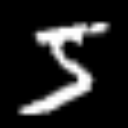

In [2]:
torchvision.transforms.Resize([128,128])(mnist_train.__getitem__(0)[0])

In [3]:
torchvision.transforms.functional.pil_to_tensor(mnist_train.__getitem__(0)[0])

tensor([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
           18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,

In [4]:
mnist_train.__getitem__(0)[1]

5

The sizes of all images are 28x28.

In [5]:
mnist_train.__getitem__(0)[0].size

(28, 28)

The training set has 60000 images, the test set has 10000 images.

In [6]:
mnist_train.__len__ 

<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 60000
    Root location: C:/Users/elini/Desktop/nine circles 2
    Split: Train>

In [7]:
mnist_test.__len__ 

<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 10000
    Root location: C:/Users/elini/Desktop/nine circles 2
    Split: Test>

### Fashion-MNIST <a class="anchor" id="Fashion-MNIST"></a>

While the MNIST dataset is still used in the machine learning community for simple demonstrations, it is considered nowadays too easy to distinguish performance among modern classification algorithms (it is not hard to achieve an accuracy of over 99% on the validation set). The Fashion-MNIST dataset aims to address the shortcomings of the original MNIST dataset while keeping the same basic structure: 70,000 28x28 grayscale images splitted into 10 categories (T-shirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot) [[3](#3)].

In [8]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(root = 'C:/Users/elini/Desktop/nine circles 2', train = True,  download = True)
fashion_mnist__test = torchvision.datasets.FashionMNIST(root = 'C:/Users/elini/Desktop/nine circles 2', train = False,  download = True)

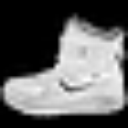

In [9]:
torchvision.transforms.Resize([128,128])(fashion_mnist_train.__getitem__(0)[0])

In [10]:
fashion_mnist_train.__getitem__(0)[1]

9

In [11]:
fashion_mnist_train.__getitem__(0)[0].size

(28, 28)

The training set has again 60000 images.

In [12]:
fashion_mnist_train.__len__ 

<bound method MNIST.__len__ of Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: C:/Users/elini/Desktop/nine circles 2
    Split: Train>

In [13]:
fashion_mnist__test.__len__ 

<bound method MNIST.__len__ of Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: C:/Users/elini/Desktop/nine circles 2
    Split: Test>

### CIFAR-10 <a class="anchor" id="CIFAR-10"></a>

CIFAR (Canadian Institute For Advanced Research)-10 (https://www.cs.toronto.edu/~kriz/cifar.html) is another widely popular dataset of images for image recognition. It contains 60000 32x32 color images from ten categories (airplane, car, bird, cat, deer, dog, frog, horse, ships, and truck).

In [14]:
cifar10_train = torchvision.datasets.CIFAR10(root = 'C:/Users/elini/Desktop/nine circles 2', train = True,  download = True)
cifar10__test = torchvision.datasets.CIFAR10(root = 'C:/Users/elini/Desktop/nine circles 2', train = False,  download = True)

In [15]:
cifar10_train.__getitem__(2)

(<PIL.Image.Image image mode=RGB size=32x32>, 9)

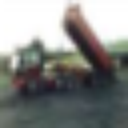

In [16]:
torchvision.transforms.Resize([128,128])(cifar10_train.__getitem__(2)[0])

In [17]:
cifar10_train.__getitem__(0)[0].size

(32, 32)

We observe that the training set has 50000 images nad the test se 10000.

In [18]:
cifar10_train.__len__ 

<bound method CIFAR10.__len__ of Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:/Users/elini/Desktop/nine circles 2
    Split: Train>

In [19]:
cifar10__test.__len__ 

<bound method CIFAR10.__len__ of Dataset CIFAR10
    Number of datapoints: 10000
    Root location: C:/Users/elini/Desktop/nine circles 2
    Split: Test>

## LeNet  <a class="anchor" id="LeNet"></a>  

As we have discussed in the introduction, convolutions play an important role in signal/image processing, and because they are linear transformations of inputs, it makes sense to incorporate them into neural network architectures for tasks such as image recognition.  Moreover, unlike fully connected neural networks, convolutional layers have significantly fewer parameters, since the convolution kernel can be much smaller than the original image.


To get a better idea of how such a convolutional neural network looks, let us have a look at one of the first convolutional neural networks (CNNs), *LeNet* (LeNet-5 to be more precise) developed in AT&T Bell Laboratories between 1989 and 1998 [[1](#1), [2](#2)].

In [20]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

np.set_printoptions(legacy='1.25')

In [21]:
import torch
from torch import nn

class LeNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.lenet_stack = nn.Sequential(
            nn.Conv2d(in_channels = num_channels, out_channels = 6, kernel_size = 5, stride = 1, padding = 2, padding_mode='zeros'), # 2d conv: six 5x5 kernels, padding = 2
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = 2, stride = 2), # average pooling with 2x2 kernel, stride = 2
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0), # 2d conv: sixteen 5x5 kernels, no padding
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = 2, stride = 2), # average pooling with 2x2 kernel, stride = 2
            nn.Flatten(), # flatten the output
            nn.LazyLinear(120), # LazyLinear allows us to define a linear layer without specifying the number of inputs (which depends on the size of images)
            nn.Sigmoid(),
            nn.LazyLinear(84),
            nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x):
        output = self.lenet_stack(x)
        return output

We observe that LeNet-5 starts with a 2D convolutional layer that produces six transformed images. We should note that *padding* enlarges the original image to ensure that convolution is well-defined for pixels on the boundary and those close to it (the required size of padding depends on the convolution kernel size). Without specifying padding, these pixels are ignored, and the resulting transformed image becomes smaller. The type of padding is defined by *padding_mode*: 'zeros' simply means that the image is padded with zeros. This approach has the disadvantage of "darkening" the convolution results for boundary pixels. Thus, other strategies, such as reflecting or repeating the image, are also available. We should also note that the results of convolutions are then non-linearly transformed using the sigmoid activation function, ensuring the neural network is not merely a linear model. 

Next, *average pooling* is performed. This is a simple convolution that averages pixel values within a given kernel for each image. We should also mention the parameter *stride*, which, when greater than 1, indicates downsampling: during convolution, stride determines how many pixels are skipped in each dimension. In our case, stride is 2, so one pixel is skipped in both dimensions, resulting in a downsampling factor of 2 (e.g., from 64x64 to 32x32). Overall, the result will be six averaged and downsampled images. 

Average pooling is followed by another convolutional layer. Since we are now dealing with six transformed images (aka 6 channels), each "individual" convolution operator within *Conv2d* consists of six 5x5 kernels. During convolution, each kernel is applied to its image, and the results for the corresponding pixels (with the same coordinates) in each figure are simply added, i.e., the result is *one* image (see https://medium.com/data-science/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148 for a nice illustration of all of these operations). On this layer, we have sixteen convolution operators, and thus, the outputs are *sixteen transformed images*. These are then averaged and downsampled again via another *AvgPool2d*.

Finally, the transformed images are stacked into a single vector, and we can interpret these as features extracted by the convolutional layers. The image is then classified using the extracted features by a fully connected perceptron with two hidden layers.

### Training LeNet on MNIST <a class="anchor" id="lenet_mnist"></a>

Let us train LeNet-5 on the MNIST dataset for which LeNet was originally designed [[1](#1)]. Both the training and test datasets are ready to loaded with *DataLoader*; we just need to transform images into tensors using *torchvision.transforms.ToTensor* (this transformation scales it to $[0, 1]$). We will then also perform *torchvision.transforms.Normalize* transform to rescale the pixel values from $[0, 1]$ to $[-1, 1]$.

In [22]:
from torch.utils.data import DataLoader

transforms_mnist =  torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), # transform to a tensor with values in [0,1]
    torchvision.transforms.Normalize(0.5, 0.5)] # rescale to [-1, 1]
)

mnist_train = torchvision.datasets.MNIST(root = 'C:/Users/elini/Desktop/nine circles 2', train = True,  download = True, transform = transforms_mnist)
mnist_test = torchvision.datasets.MNIST(root = 'C:/Users/elini/Desktop/nine circles 2', train = False,  download = True, transform = transforms_mnist)

mnist_train_loader = DataLoader(dataset = mnist_train, batch_size = 500, shuffle = True) 
mnist_test_loader = DataLoader(dataset = mnist_test, batch_size = 10000, shuffle = True) 

We are classifying grayscale images of the digits zero to nine. Consequently, we use LeNet with one input channel and 10 outputs.

In [23]:
LeNet_MNIST = LeNet(1,10)

LeNet uses sigmoid activation functions; therefore, we will use Xavier initialization.

In [24]:
def init_weights_xavier(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_uniform_(model.weight, gain = 1.0) 
        nn.init.constant_(model.bias, 0)   
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_uniform_(model.weight, gain = 1.0) 
        nn.init.constant_(model.bias, 0)   

We are using *LazyLinear* layers in our model, so the LeNet model does not have full specifications for the number of weights (remember, we did not specify the image size when constructing LeNet). Hence, we first need to perform a forward pass on an image.

In [25]:
# LeNet_MNIST.apply(init_weights_xavier) 

# will cause error:
# ValueError: Attempted to use an uninitialized parameter in <method 'dim' of 'torch._C.TensorBase' objects>. This error happens when you are 
# using a `LazyModule` or explicitly manipulating `torch.nn.parameter.UninitializedParameter` objects. When using LazyModules Call `forward` 
# with a dummy batch to initialize the parameters before calling torch functions

In [26]:
x = mnist_train.__getitem__(0)[0] 
x = x[None,:,:,:]

LeNet_MNIST(x)

tensor([[-0.1336,  0.0009,  0.2322,  0.0729,  0.2523, -0.3923,  0.0507, -0.5031,
          0.1411,  0.4550]], grad_fn=<AddmmBackward0>)

We obtained 10 real outputs. To get class probabilities, we just need to use *softmax* transformation $$p_i(x) = \frac{e^{f_i(x)}}{\sum_{i = 1}^{10} e^{f_i(x)}},$$
where $f_i(x)$ is the i-th output of LeNet $f = (f_1, \cdots ,f_{10})$. Consequently, we can observe that LeNet is essentially a nonlinear version of a multinomial logistic regression (also known as softmax regression in the context of machine learning).

In [27]:
softmax = torch.nn.Softmax(dim = 1)
softmax(LeNet_MNIST(x))

tensor([[0.0829, 0.0948, 0.1195, 0.1019, 0.1219, 0.0640, 0.0996, 0.0573, 0.1090,
         0.1493]], grad_fn=<SoftmaxBackward0>)

We can now check that our LeNet implementation successfully evaluates whole batches of images.

In [28]:
for batch, (X, y) in enumerate(mnist_train_loader):
    pred_logits = LeNet_MNIST(X)
    
pred_logits

tensor([[-0.1336,  0.0010,  0.2322,  ..., -0.5030,  0.1411,  0.4550],
        [-0.1336,  0.0010,  0.2321,  ..., -0.5032,  0.1409,  0.4550],
        [-0.1336,  0.0012,  0.2320,  ..., -0.5031,  0.1410,  0.4548],
        ...,
        [-0.1336,  0.0012,  0.2322,  ..., -0.5032,  0.1409,  0.4549],
        [-0.1335,  0.0010,  0.2321,  ..., -0.5031,  0.1410,  0.4550],
        [-0.1336,  0.0011,  0.2322,  ..., -0.5031,  0.1410,  0.4549]],
       grad_fn=<AddmmBackward0>)

We observe that evaluations proceeded as expected. After these first forward passes, the "lazy" implementation has been resolved. We can now use our own weight initialization.

In [29]:
LeNet_MNIST.apply(init_weights_xavier) 

LeNet(
  (lenet_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

We observe that the number of features in the first linear layers corresponds to the architecture of LeNet from https://en.wikipedia.org/wiki/LeNet (5x5x16 = 400).

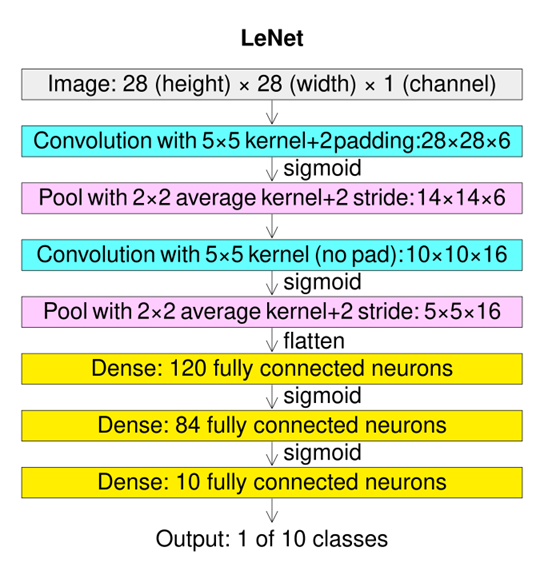

Lastly, we need to define a loss function and select an optimizer. We will use the usual multinomial log-likelihood (*nn.CrossEntropyLoss*) as the loss function and mini-batch GD as an optimizer. We will use the *ReduceLROnPlateau* learning rate schedule, which decreases the learning rate by a *factor* whenever the given score does not decrease for the *patience* number of iterations.

In [30]:
cross_entropy_loss = nn.CrossEntropyLoss()
optim_SGD =  torch.optim.SGD(LeNet_MNIST.parameters(), lr = 0.1, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_SGD, factor = 0.5, patience = 4, threshold = 0.1)

Our training and test loop will be as follows.

In [31]:
def train_test_loop_lenet(train_data_loader, test_data_loader, model, loss_fn, optimizer, scheduler):
    
    softmax = torch.nn.Softmax(dim = 1)
    model.train()

    loss_sum_train  = 0
    accu_sum_train = 0
    size_train = 0

    
    for batch, (X, y) in enumerate(train_data_loader):

        optimizer.zero_grad() # zero out the gradients
        
        pred_logits = model(X) # forward pass
        loss = loss_fn(pred_logits, y) # loss evaluation 

        # Backpropagation
        loss.backward() # gradient evaluation
        optimizer.step() # SGD step
        

        # compute prediction epoch loss and accuracy
        with torch.no_grad(): # we do not need to compute the gradients
            loss_sum_train = loss_sum_train + loss*len(X)
            size_train = size_train + len(X)
            accu_sum_train = accu_sum_train + ((softmax(pred_logits).argmax(dim = 1)-y).abs() == 0).long().sum()

    # evaluate performance on the test set
    with torch.no_grad(): 
        
        loss_sum_train = loss_sum_train/size_train
        accu_sum_train = accu_sum_train/size_train
        
        model.eval() 
        loss_sum_test  = 0
        accu_sum_test = 0
        size_test = 0
        
        for batch, (X_test, y_test) in enumerate(test_data_loader):
            pred_logits_test = model(X_test)
            loss_sum_test = loss_sum_test + loss_fn(pred_logits_test, y_test)*len(X_test)
            accu_sum_test = accu_sum_test + ((softmax(pred_logits_test).argmax(dim = 1)-y_test).abs() == 0).long().sum()
            size_test = size_test + len(X_test)

        loss_sum_test = loss_sum_test/size_test
        accu_sum_test = accu_sum_test/size_test
        
    # learning rate step; we use loss_sum_train for ReduceLROnPlateau
    learning_rate = scheduler.get_last_lr() 
    scheduler.step(loss_sum_train) 
    
    return  loss_sum_train.detach(), loss_sum_test.detach(), learning_rate[0], accu_sum_train.detach(), accu_sum_test.detach()

In [32]:
torch.manual_seed(123)
LeNet_MNIST.apply(init_weights_xavier) 

n_epochs = 50

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
accu_epochs_train = np.zeros(n_epochs) 
accu_epochs_test = np.zeros(n_epochs) 

learning_rates = np.zeros(n_epochs)
loss = nn.CrossEntropyLoss()

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t], accu_epochs_train[t], accu_epochs_test[t]   = train_test_loop_lenet(mnist_train_loader, mnist_test_loader, LeNet_MNIST, cross_entropy_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

606.4717338085175


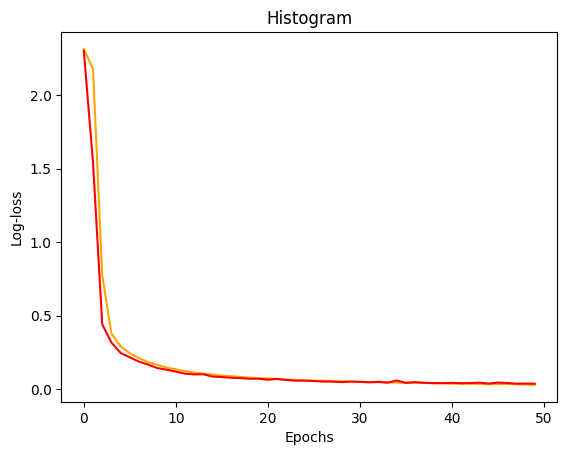

In [33]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

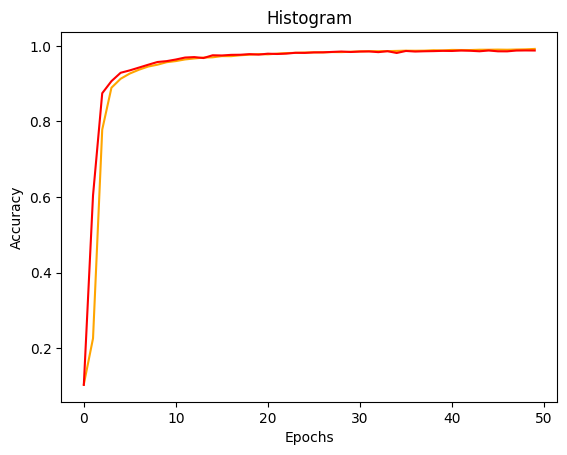

In [34]:
plt.plot(accu_epochs_train, color = 'orange')
plt.plot(accu_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

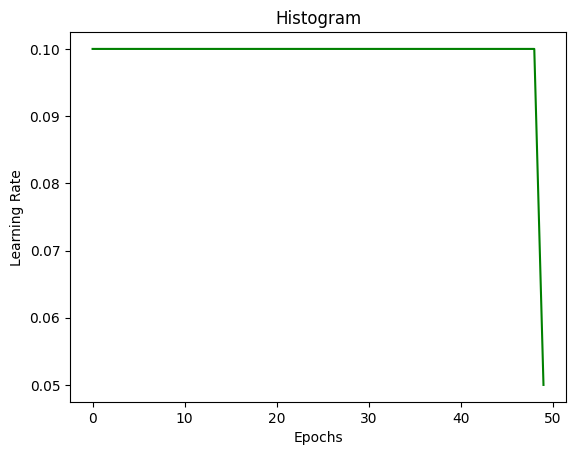

In [35]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

In [36]:
accu_epochs_train[49]

0.9918166399002075

In [37]:
accu_epochs_test[49]

0.9876000285148621

We attained almost 99% accuracy on the test set.

### Training CNNs on GPU <a class="anchor" id="gpu"></a>

As we start dealing with more complex neural networks, evaluating them will become faster on a GPU (which is better suited to many parallelizable simple operations than a CPU). We first need to check whether a suitable GPU  is available.

In [38]:
torch.cuda.is_available()

True

In [39]:
cuda_device = torch.device('cuda')
torch.cuda.get_device_name(cuda_device)

'NVIDIA GeForce RTX 3050 Laptop GPU'

We then create a new neural network and assign it to GPU.

In [40]:
LeNet_MNIST_cuda = LeNet(1,10).to(cuda_device)
LeNet_MNIST_cuda(x.to(cuda_device));

Next, we need to alter the training loop so that batches are moved to the GPU as well.

In [41]:
def train_test_loop_lenet_cuda(train_data_loader, test_data_loader, model, loss_fn, optimizer, scheduler):
    
    softmax = torch.nn.Softmax(dim = 1)
    model.train()

    loss_sum_train  = 0
    accu_sum_train = 0
    size_train = 0

    
    for batch, (X, y) in enumerate(train_data_loader):

        X = X.to(cuda_device)
        y = y.to(cuda_device)

        optimizer.zero_grad() # zero out the gradients
        
        pred_logits = model(X) # forward pass
        loss = loss_fn(pred_logits, y) # loss evaluation 

        # Backpropagation
        loss.backward() # gradient evaluation
        optimizer.step() # SGD step
        

        # compute prediction epoch loss and accuracy
        with torch.no_grad(): # we do not need to compute the gradients
            loss_sum_train = loss_sum_train + loss*len(X)
            size_train = size_train + len(X)
            accu_sum_train = accu_sum_train + ((softmax(pred_logits).argmax(dim = 1)-y).abs() == 0).long().sum()

    # evaluate performance on the test set
    with torch.no_grad(): 
        
        loss_sum_train = loss_sum_train/size_train
        accu_sum_train = accu_sum_train/size_train
        
        model.eval() 
        loss_sum_test  = 0
        accu_sum_test = 0
        size_test = 0
        
        for batch, (X_test, y_test) in enumerate(test_data_loader):

            X_test = X_test.to(cuda_device)
            y_test = y_test.to(cuda_device)
            
            pred_logits_test = model(X_test)
            loss_sum_test = loss_sum_test + loss_fn(pred_logits_test, y_test)*len(X_test)
            accu_sum_test = accu_sum_test + ((softmax(pred_logits_test).argmax(dim = 1)-y_test).abs() == 0).long().sum()
            size_test = size_test + len(X_test)

        loss_sum_test = loss_sum_test/size_test
        accu_sum_test = accu_sum_test/size_test
        
    # learning rate step; we use loss_sum_train for ReduceLROnPlateau
    learning_rate = scheduler.get_last_lr() 
    scheduler.step(loss_sum_train) 
    
    return  loss_sum_train.detach(), loss_sum_test.detach(), learning_rate[0], accu_sum_train.detach(), accu_sum_test.detach()

Let us train LeNet on the GPU.

In [42]:
torch.manual_seed(123)
LeNet_MNIST_cuda.apply(init_weights_xavier) 

optim_SGD_cuda =  torch.optim.SGD(LeNet_MNIST_cuda.parameters(), lr = 0.1, momentum = 0.9)
scheduler_cuda = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_SGD_cuda, factor = 0.5, patience = 4, threshold = 0.1)

n_epochs = 50

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
accu_epochs_train = np.zeros(n_epochs) 
accu_epochs_test = np.zeros(n_epochs) 

learning_rates = np.zeros(n_epochs)
loss = nn.CrossEntropyLoss()

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t], accu_epochs_train[t], accu_epochs_test[t]   = train_test_loop_lenet_cuda(mnist_train_loader, mnist_test_loader, LeNet_MNIST_cuda, cross_entropy_loss, optim_SGD_cuda, scheduler_cuda)
end = time.time()
print(end - start)

448.12083745002747


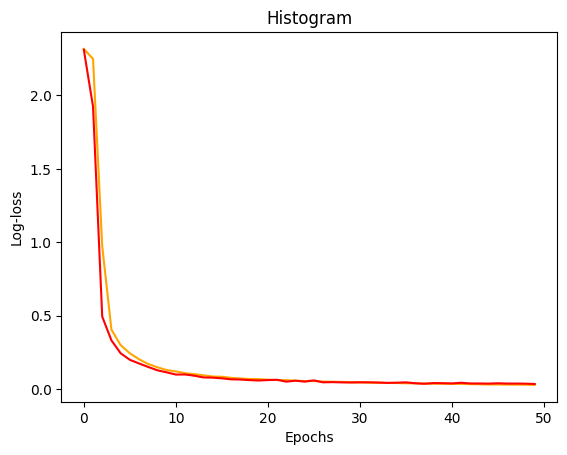

In [43]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

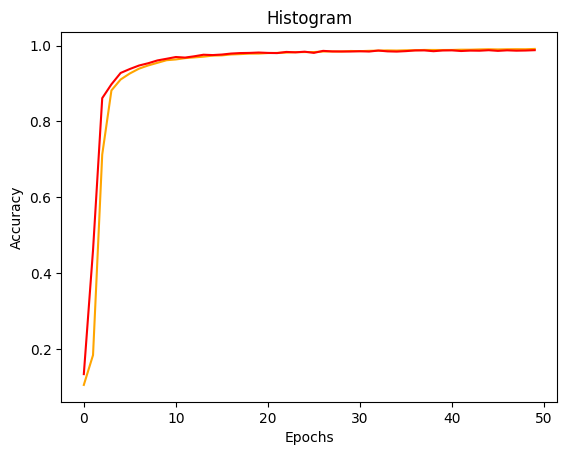

In [44]:
plt.plot(accu_epochs_train, color = 'orange')
plt.plot(accu_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

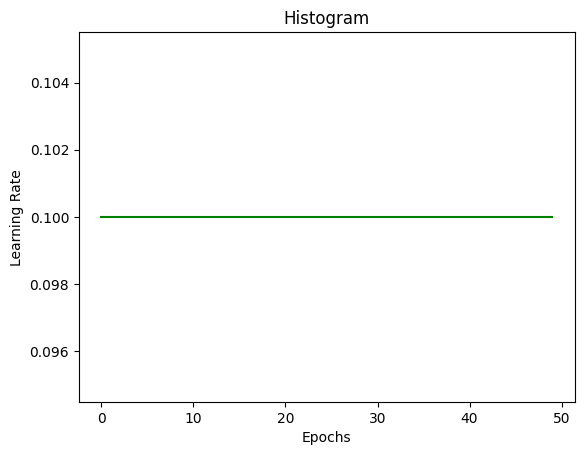

In [45]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

In [46]:
accu_epochs_train[49]

0.9912166595458984

In [47]:
accu_epochs_test[49]

0.9878999590873718

In this case, we observe a moderately faster computational time on the GPU. 

### Training LeNet on Fashion-MNIST <a class="anchor" id="lenet_fashion_mnist"></a>

Next, we will move to the Fashion-MNIST dataset. We just need to change the loader, the size of the images, and hence, the architecture of LeNet is the same.

In [48]:
transforms_fashion_mnist =  torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)]
)

fashion_mnist_train = torchvision.datasets.FashionMNIST(root = 'C:/Users/elini/Desktop/nine circles 2', train = True,  download = True, transform = transforms_fashion_mnist)
fashion_mnist__test = torchvision.datasets.FashionMNIST(root = 'C:/Users/elini/Desktop/nine circles 2', train = False,  download = True, transform = transforms_fashion_mnist)

fashion_mnist_train_loader = DataLoader(dataset = fashion_mnist_train, batch_size = 500, shuffle = True) 
fashion_mnist_test_loader = DataLoader(dataset = fashion_mnist__test, batch_size = 10000, shuffle = True) 

In [49]:
torch.manual_seed(123)
LeNet_MNIST_cuda.apply(init_weights_xavier) 
optim_SGD_cuda =  torch.optim.SGD(LeNet_MNIST_cuda.parameters(), lr = 0.1, momentum = 0.9)
scheduler_cuda = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_SGD_cuda, factor = 0.5, patience = 4, threshold = 0.1)

n_epochs = 50

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
accu_epochs_train = np.zeros(n_epochs) 
accu_epochs_test = np.zeros(n_epochs) 

learning_rates = np.zeros(n_epochs)
loss = nn.CrossEntropyLoss()

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t], accu_epochs_train[t], accu_epochs_test[t]   = train_test_loop_lenet_cuda(fashion_mnist_train_loader, fashion_mnist_test_loader, LeNet_MNIST_cuda, cross_entropy_loss, optim_SGD_cuda, scheduler_cuda)
end = time.time()
print(end - start)

448.4621090888977


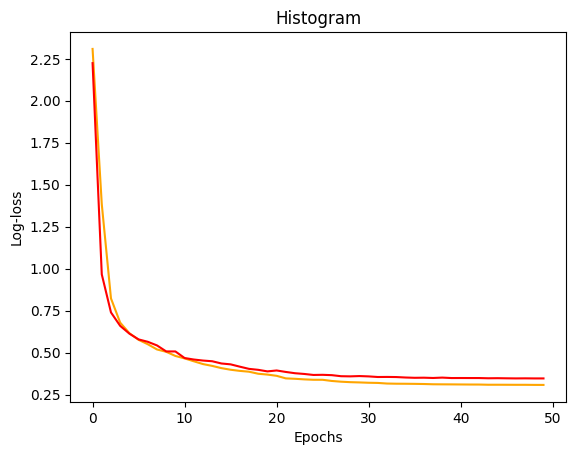

In [50]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

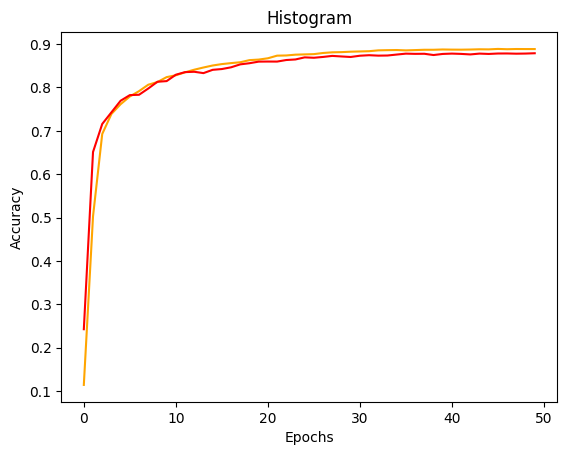

In [51]:
plt.plot(accu_epochs_train, color = 'orange')
plt.plot(accu_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

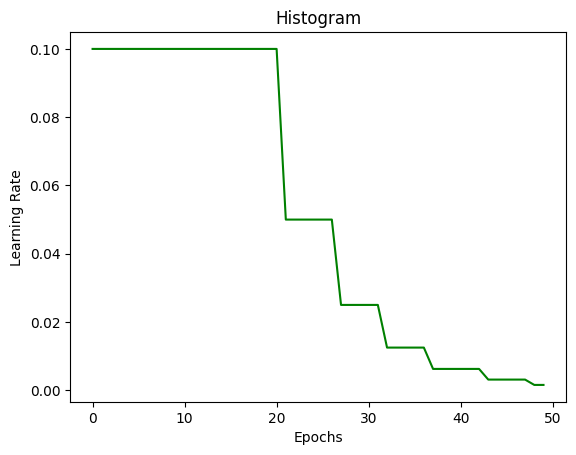

In [52]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

In [53]:
accu_epochs_train[49]

0.8884666562080383

In [54]:
accu_epochs_test[49]

0.8787999749183655

We observe that LeNet's performance on Fashion-MNIST is significantly worse. Let us try to improve LeNet by introducing more "modern" elements. We start with replacing the sigmoid activation functions with ReLU.

In [55]:
class LeNet_mod(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.lenet_stack = nn.Sequential(
            nn.Conv2d(in_channels = num_channels, out_channels = 6, kernel_size = 5, stride = 1, padding = 2, padding_mode='zeros'), # 2d conv: six 5x5 kernels, padding = 2
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2), # average pooling with 2x2 kernel, stride = 2
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0), # 2d conv: sixteen 5x5 kernels, no padding
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2), # average pooling with 2x2 kernel, stride = 2
            nn.Flatten(), # flatten the output
            nn.LazyLinear(120), # LazyLinear allows us to define a linear layer without specifying the number of inputs (which depends on the size of images)
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x):
        output = self.lenet_stack(x)
        return output

In [56]:
def init_weights_he(model):
    if isinstance(model, nn.Linear):
        nn.init.kaiming_normal_(model.weight, nonlinearity = 'relu') 
        nn.init.constant_(model.bias, 0)       

In [57]:
LeNet_MNIST_cuda_mod = LeNet_mod(1,10).to(cuda_device)

x = fashion_mnist_train.__getitem__(0)[0] 
x = x[None,:,:,:]

LeNet_MNIST_cuda_mod(x.to(cuda_device));

In [58]:
torch.manual_seed(123)
LeNet_MNIST_cuda_mod.apply(init_weights_he) # He initialization for ReLU
optim_SGD_cuda = torch.optim.SGD(LeNet_MNIST_cuda_mod.parameters(), lr = 0.1, momentum = 0.9)
scheduler_cuda = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_SGD_cuda, factor = 0.5, patience = 4, threshold = 0.1)

n_epochs = 50

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
accu_epochs_train = np.zeros(n_epochs) 
accu_epochs_test = np.zeros(n_epochs) 

learning_rates = np.zeros(n_epochs)
loss = nn.CrossEntropyLoss()

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t], accu_epochs_train[t], accu_epochs_test[t]   = train_test_loop_lenet_cuda(fashion_mnist_train_loader, fashion_mnist_test_loader, LeNet_MNIST_cuda_mod, cross_entropy_loss, optim_SGD_cuda, scheduler_cuda)
end = time.time()
print(end - start)

446.29881286621094


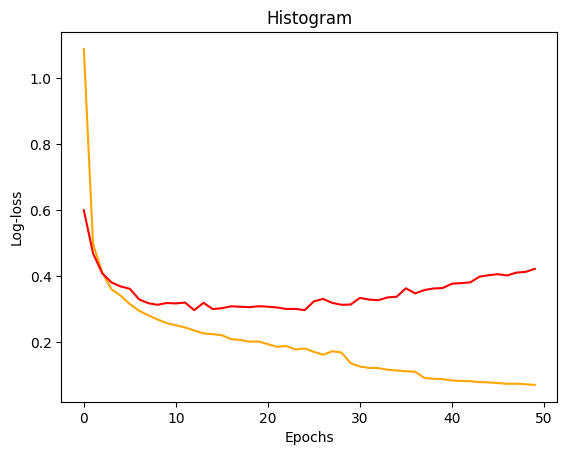

In [59]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

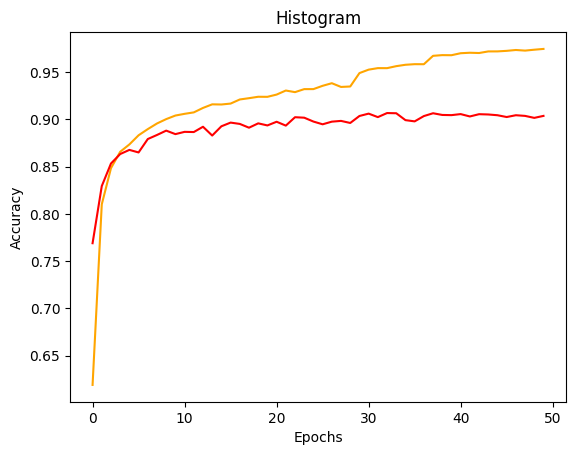

In [60]:
plt.plot(accu_epochs_train, color = 'orange')
plt.plot(accu_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

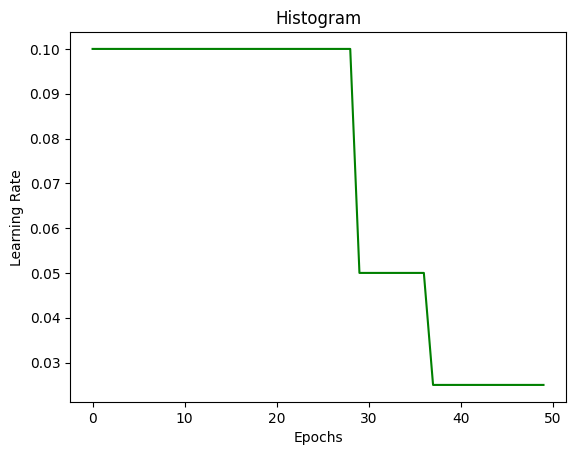

In [61]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

In [62]:
accu_epochs_train[49]

0.9746000170707703

In [63]:
accu_epochs_test[49]

0.9036999940872192

We observe that the LeNet with ReLU activations would probably benefit from further regularization on this dataset. Hence, let us add two dropout layers to the classification layers.

In [64]:
class LeNet_mod2(nn.Module):
    def __init__(self, num_channels, num_classes, p_dropout):
        super().__init__()
        self.lenet_stack = nn.Sequential(
            nn.Conv2d(in_channels = num_channels, out_channels = 6, kernel_size = 5, stride = 1, padding = 2, padding_mode='zeros'), # 2d conv: six 5x5 kernels, padding = 2
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2), # average pooling with 2x2 kernel, stride = 2
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0), # 2d conv: sixteen 5x5 kernels, no padding
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2), # average pooling with 2x2 kernel, stride = 2
            nn.Flatten(), # flatten the output
            nn.LazyLinear(120), #
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x):
        output = self.lenet_stack(x)
        return output

In [65]:
LeNet_MNIST_cuda_mod2 = LeNet_mod2(1,10,0.5).to(cuda_device)

x = fashion_mnist_train.__getitem__(0)[0] 
x = x[None,:,:,:]

LeNet_MNIST_cuda_mod2(x.to(cuda_device));

In [66]:
torch.manual_seed(123)
LeNet_MNIST_cuda_mod2.apply(init_weights_he) 
optim_SGD_cuda = torch.optim.SGD(LeNet_MNIST_cuda_mod2.parameters(), lr = 0.1, momentum = 0.9)
scheduler_cuda = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_SGD_cuda, factor = 0.5, patience = 4, threshold = 0.1)

n_epochs = 50

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
accu_epochs_train = np.zeros(n_epochs) 
accu_epochs_test = np.zeros(n_epochs) 

learning_rates = np.zeros(n_epochs)
loss = nn.CrossEntropyLoss()

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t], accu_epochs_train[t], accu_epochs_test[t]   = train_test_loop_lenet_cuda(fashion_mnist_train_loader, fashion_mnist_test_loader, LeNet_MNIST_cuda_mod2, cross_entropy_loss, optim_SGD_cuda, scheduler_cuda)
end = time.time()
print(end - start)

448.86255860328674


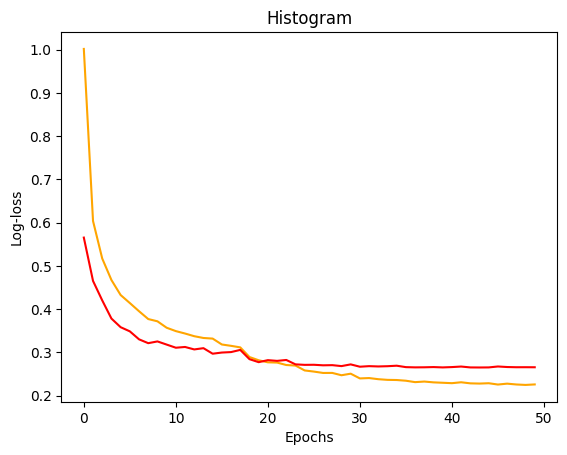

In [67]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

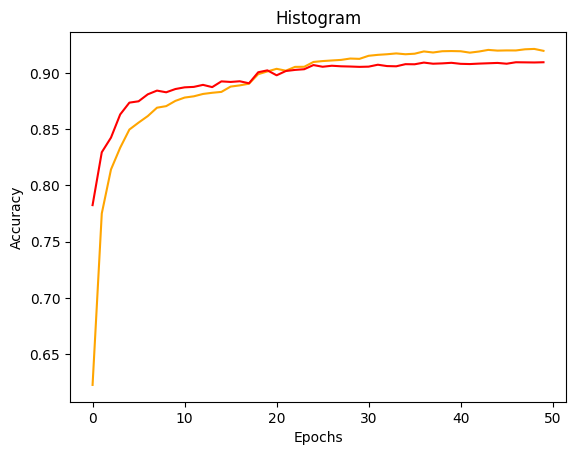

In [68]:
plt.plot(accu_epochs_train, color = 'orange')
plt.plot(accu_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

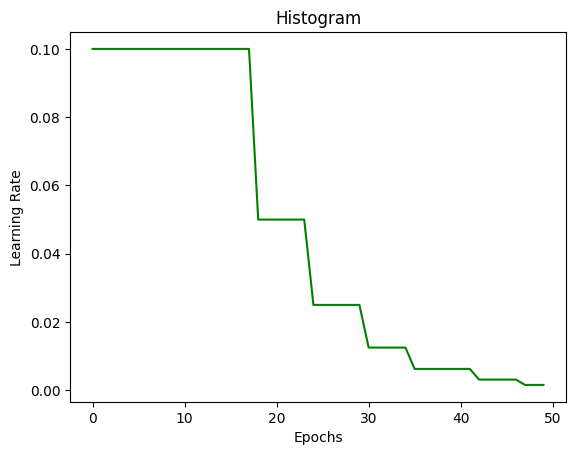

In [69]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

In [70]:
accu_epochs_train[49]

0.9196500182151794

In [71]:
accu_epochs_test[49]

0.909500002861023

We slightly improved the overall accuracy on the test set, from 87.9% to over 90.7%.

### Training LeNet on CIFAR-10 <a class="anchor" id="lenet_CIFAR_10"></a>

Lastly, let us move to the CIFAR-10 dataset. This dataset contains colored images. Thus, we must increase the number of input channels from 1 to 3. This dataset also contains slightly larger images, so the number of weights in the LeNet neural network will differ slightly.  

In [72]:
transforms_cifar10 =  torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])]
)

cifar10_train = torchvision.datasets.CIFAR10(root = 'C:/Users/elini/Desktop/nine circles 2', train = True,  download = True, transform = transforms_cifar10)
cifar10__test = torchvision.datasets.CIFAR10(root = 'C:/Users/elini/Desktop/nine circles 2', train = False,  download = True, transform = transforms_cifar10)

cifar10_train_loader = DataLoader(dataset = cifar10_train, batch_size = 500, shuffle = True) 
cifar10__test_loader = DataLoader(dataset = cifar10__test, batch_size = 10000, shuffle = True) 

In [73]:
LeNet_cifar10_cuda = LeNet(3,10).to(cuda_device)

x = cifar10_train.__getitem__(0)[0] 
x = x[None,:,:,:]

LeNet_cifar10_cuda(x.to(cuda_device));

In [74]:
torch.manual_seed(123)
LeNet_cifar10_cuda.apply(init_weights_xavier)

LeNet(
  (lenet_stack): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=576, out_features=120, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

Let us train our models. We start with the original LeNet model.

In [75]:
optim_SGD_cuda =  torch.optim.SGD(LeNet_cifar10_cuda.parameters(), lr = 0.1, momentum = 0.9)
scheduler_cuda = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_SGD_cuda, factor = 0.5, patience = 10, threshold = 0.1)

n_epochs = 200

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
accu_epochs_train = np.zeros(n_epochs) 
accu_epochs_test = np.zeros(n_epochs) 

learning_rates = np.zeros(n_epochs)
loss = nn.CrossEntropyLoss()

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t], accu_epochs_train[t], accu_epochs_test[t]  = train_test_loop_lenet_cuda(cifar10_train_loader, cifar10__test_loader, LeNet_cifar10_cuda, cross_entropy_loss, optim_SGD_cuda, scheduler_cuda)
end = time.time()
print(end - start)

1847.00097322464


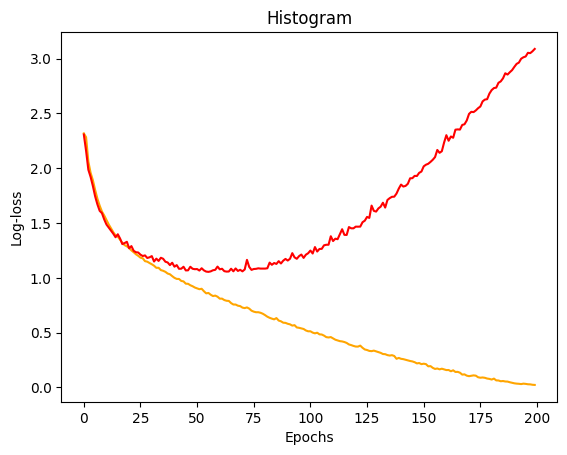

In [76]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

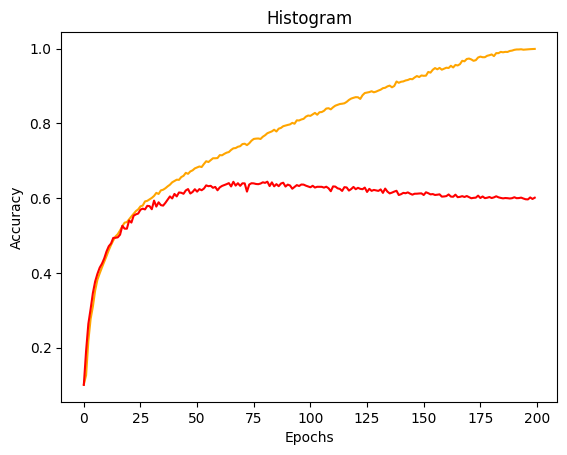

In [77]:
plt.plot(accu_epochs_train, color = 'orange')
plt.plot(accu_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

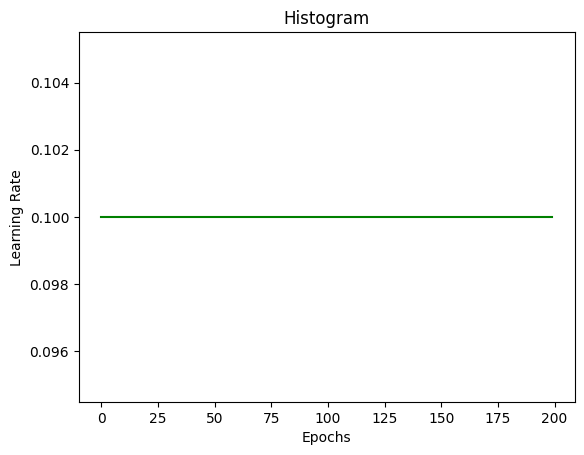

In [78]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

In [79]:
accu_epochs_train[199]

0.9996399879455566

In [80]:
accu_epochs_test[199]

0.6013000011444092

In [81]:
accu_epochs_test.max()

0.6441999673843384

We observe that the standard model does not seem to generalize well. Let us try the modified LeNet model next.

In [83]:
LeNet_cifar10_cuda_mod2 = LeNet_mod2(3,10,0.5).to(cuda_device)

x = cifar10_train.__getitem__(0)[0] 
x = x[None,:,:,:]

LeNet_cifar10_cuda_mod2(x.to(cuda_device));

In [84]:
torch.manual_seed(123)
LeNet_cifar10_cuda_mod2.apply(init_weights_he) 
optim_SGD_cuda =  torch.optim.SGD(LeNet_cifar10_cuda_mod2.parameters(), lr = 0.1, momentum = 0.9)
scheduler_cuda = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_SGD_cuda, factor = 0.5, patience = 10, threshold = 0.1)

n_epochs = 200

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
accu_epochs_train = np.zeros(n_epochs) 
accu_epochs_test = np.zeros(n_epochs) 

learning_rates = np.zeros(n_epochs)
loss = nn.CrossEntropyLoss()

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t], accu_epochs_train[t], accu_epochs_test[t]   = train_test_loop_lenet_cuda(cifar10_train_loader, cifar10__test_loader, LeNet_cifar10_cuda_mod2, cross_entropy_loss, optim_SGD_cuda, scheduler_cuda)
end = time.time()
print(end - start)

1843.264533996582


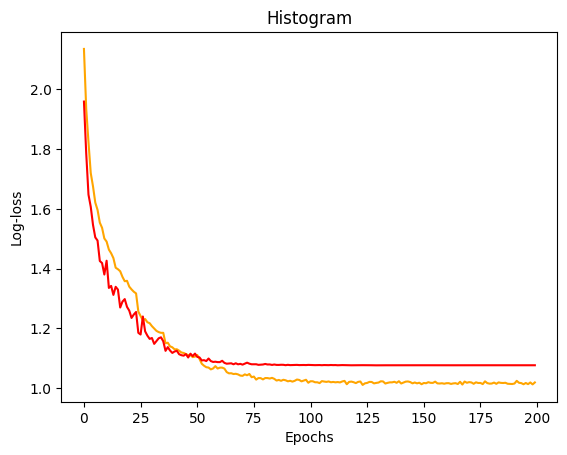

In [85]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

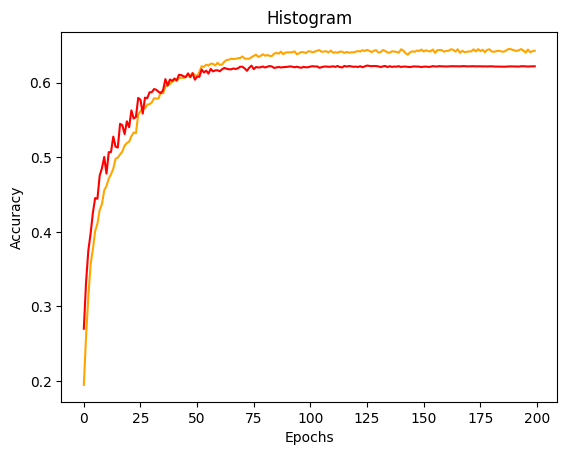

In [86]:
plt.plot(accu_epochs_train, color = 'orange')
plt.plot(accu_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

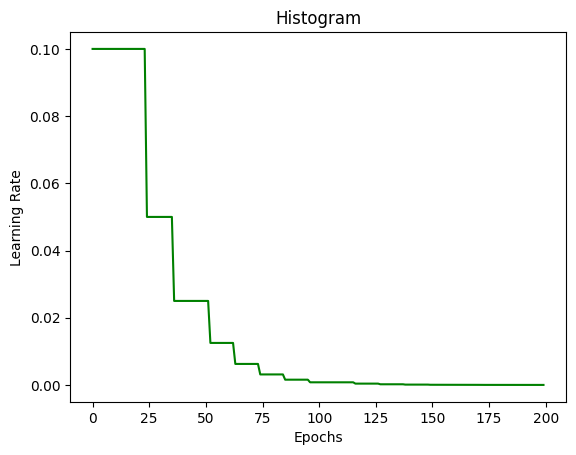

In [87]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

In [88]:
accu_epochs_train[199]

0.6428200006484985

In [89]:
accu_epochs_test[199]

0.621999979019165

In [90]:
accu_epochs_test.max()

0.6229999661445618

We observe that our model's performance did not improve. However, the performance on the test set at least does not deteriorate as the training progresses.

## Data Augmentation <a class="anchor" id="data_aug"></a>

Data augmentation is a set of techniques that train the model on altered versions of the original training dataset [[2](#2)]. For example, if we flip an image horizontally (via *torchvision.transforms.RandomHorizontalFlip*), we get a slightly different image that still belongs to the same class.

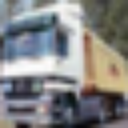

In [102]:
cifar10_set = torchvision.datasets.CIFAR10(root = 'C:/Users/elini/Desktop/nine circles 2', train = True,  download = True)
torchvision.transforms.RandomHorizontalFlip(0.0)(torchvision.transforms.Resize([128,128])(cifar10_set.__getitem__(1)[0]))

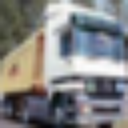

In [103]:
torchvision.transforms.RandomHorizontalFlip(1.0)(torchvision.transforms.Resize([128,128])(cifar10_set.__getitem__(1)[0]))

Similarly, we can extract a random, slightly smaller subimage of the original image.

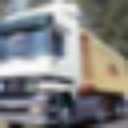

In [104]:
torchvision.transforms.Resize([128,128])(torchvision.transforms.RandomResizedCrop(size=[32,32], scale = [0.9,1.0])(cifar10_set.__getitem__(1)[0]))

By using data augmentation, we effectively enlarge our training dataset and, hopefully, make the classification algorithm more robust to slight data alterations.

Let us implement a simple data augmentation technique that uses randomized horizontal flipping and cropping (we could also consider random rotations, perspective shifts, brightness and contrast adjustments, color hue adjustments, random blurring, etc., see https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html for more details).

In [107]:
transforms_cifar10_train =  torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop(size=[32,32], scale = [0.9,1.0]),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])]
)

transforms_cifar10_test =  torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])]
)


cifar10_train = torchvision.datasets.CIFAR10(root = 'C:/Users/elini/Desktop/nine circles 2', train = True,  download = True, transform = transforms_cifar10_train)
cifar10__test = torchvision.datasets.CIFAR10(root = 'C:/Users/elini/Desktop/nine circles 2', train = False,  download = True, transform = transforms_cifar10_test)

cifar10_train_loader = DataLoader(dataset = cifar10_train, batch_size = 500, shuffle = True) 
cifar10__test_loader = DataLoader(dataset = cifar10__test, batch_size = 10000, shuffle = True) 

In [108]:
torch.manual_seed(123)
LeNet_cifar10_cuda_mod2.apply(init_weights_he) 
optim_SGD_cuda =  torch.optim.SGD(LeNet_cifar10_cuda_mod2.parameters(), lr = 0.1, momentum = 0.9)
scheduler_cuda = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_SGD_cuda, factor = 0.5, patience = 10, threshold = 0.1)

n_epochs = 200

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
accu_epochs_train = np.zeros(n_epochs) 
accu_epochs_test = np.zeros(n_epochs) 

learning_rates = np.zeros(n_epochs)
loss = nn.CrossEntropyLoss()

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t], accu_epochs_train[t], accu_epochs_test[t]   = train_test_loop_lenet_cuda(cifar10_train_loader, cifar10__test_loader, LeNet_cifar10_cuda_mod2, cross_entropy_loss, optim_SGD_cuda, scheduler_cuda)
end = time.time()
print(end - start)

3903.3040764331818


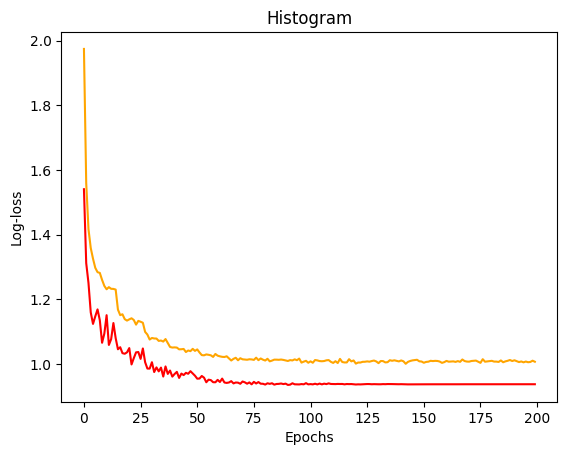

In [109]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

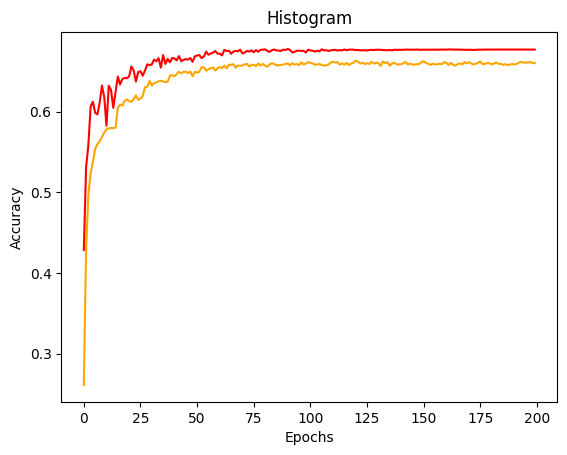

In [110]:
plt.plot(accu_epochs_train, color = 'orange')
plt.plot(accu_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

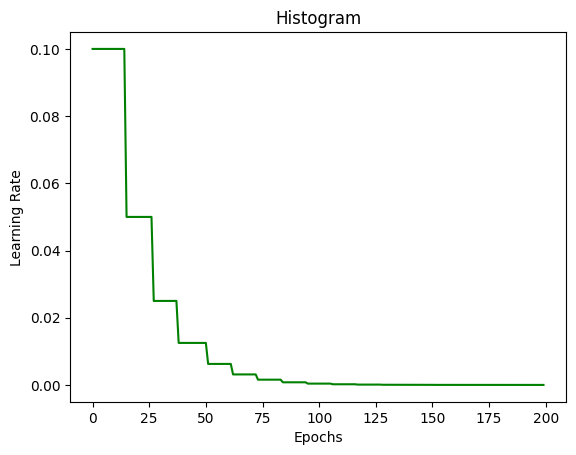

In [111]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

In [112]:
accu_epochs_train[99]

0.661359965801239

In [113]:
accu_epochs_test[99]

0.6765999794006348

In [114]:
accu_epochs_test.max()

0.6775999665260315

Data augmentation dramatically improved performance on the test set (by about 5%). Still, overall accuracy below 70% is probably not something to write home about. It seems we hit the limit of the LeNet architecture on this dataset. Hence, in the next part, we will look at further developments in CNNs beyond LeNet.

## References <a class="anchor" id="references"></a>

<a id="1">[1]</a> LECUN, Yann, et al. Gradient-based learning applied to document recognition. *Proceedings of the IEEE*, 1998, 86.11: 2278-2324.

<a id="2">[2]</a> ZHANG, Aston, et al. *Dive into deep learning*. Cambridge University Press, 2023.

<a id="3">[3]</a> XIAO, Han; RASUL, Kashif; VOLLGRAF, Roland. Fashion-mnist: a novel image dataset for benchmarking machine learning algorithms. arXiv preprint arXiv:1708.07747, 2017.